# Injuries in Collision Prediction

In [131]:
import warnings
import seaborn as sns
import pandas as pd
from sklearn import model_selection, linear_model, discriminant_analysis, ensemble
warnings.filterwarnings('ignore')
pd.set_option('display.float_format','{:.2f}'.format)
random_state=42

## Read data
+ run the collision_model_features.py file to get three data sets.
    + new_collisions
    + traffic_byhour
    + traffic_bydayofweek
+ read the three table to this notebook

In [132]:
path = '../matched_data/crash_matched_data'
collisions = pd.read_csv(
    path + '/new_collisions.csv')
traffic_byhour = pd.read_csv(
    path + '/traffic_byhour.csv')
traffic_bydayofweek = pd.read_csv(
    path + '/traffic_bydayofweek.csv')

In [133]:
# merge collisions dataset and two traffic datasets
# there may be missing values after joining, because only limited traffic volumes were only recorded on limited days
collisions = pd.merge(left=collisions, right=traffic_bydayofweek, how='left', on=['streetID','dayofweek'])
collisions = pd.merge(left=collisions, right=traffic_byhour, how='left', on=['streetID', 'time'])
collisions = collisions.dropna(subset = ['medianWeek', 'medianHour'])

# select columns that will be used in the model
collisions = collisions.loc[:,['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 
       'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 
       'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 
       'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED', 
       'dayofweek', 'time', 'speed_bumps', 'speed_limits',
       'bike_lanes', 'medianWeek', 'medianHour']]
collisions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 944783 entries, 29 to 6849496
Data columns (total 15 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   NUMBER OF PERSONS INJURED      944783 non-null  float64
 1   NUMBER OF PERSONS KILLED       944783 non-null  float64
 2   NUMBER OF PEDESTRIANS INJURED  944783 non-null  int64  
 3   NUMBER OF PEDESTRIANS KILLED   944783 non-null  int64  
 4   NUMBER OF CYCLIST INJURED      944783 non-null  int64  
 5   NUMBER OF CYCLIST KILLED       944783 non-null  int64  
 6   NUMBER OF MOTORIST INJURED     944783 non-null  int64  
 7   NUMBER OF MOTORIST KILLED      944783 non-null  int64  
 8   dayofweek                      944783 non-null  int64  
 9   time                           944783 non-null  int64  
 10  speed_bumps                    944783 non-null  float64
 11  speed_limits                   944783 non-null  float64
 12  bike_lanes                  

In [134]:
collisions.columns

Index(['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
       'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
       'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
       'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED', 'dayofweek',
       'time', 'speed_bumps', 'speed_limits', 'bike_lanes', 'medianWeek',
       'medianHour'],
      dtype='object')

In [135]:
# check if the dataset is imbalanced
print([sum(collisions['NUMBER OF PERSONS INJURED'] == 0), sum(collisions['NUMBER OF PERSONS INJURED'] > 0)])
# use undersampling to cut the number of rows for  NUMBER OF PERSONS INJURED == 0.
noinjuries = collisions.loc[collisions['NUMBER OF PERSONS INJURED'] == 0].sample(n=30000,random_state=random_state)
oneinjuries = collisions.loc[collisions['NUMBER OF PERSONS INJURED'] == 1].sample(n=30000,random_state=random_state)
twoinjuries = collisions.loc[collisions['NUMBER OF PERSONS INJURED'] == 2]
moreinjuries = collisions.loc[collisions['NUMBER OF PERSONS INJURED'] > 2]
moreinjuries['NUMBER OF PERSONS INJURED'] = 3
collisions = pd.concat([noinjuries, oneinjuries, twoinjuries, moreinjuries])

[721455, 223328]


## Number of injuries prediction
+ Quesiton: how many people will get injuried in a collision.
+ Classification problem: the outcome variable is a categorical variable. 0 people get injuried, 1 people get injuried, 2 people get injuried, and more than 3 people get injuried.
+ Method: random forest

<AxesSubplot: ylabel='Count'>

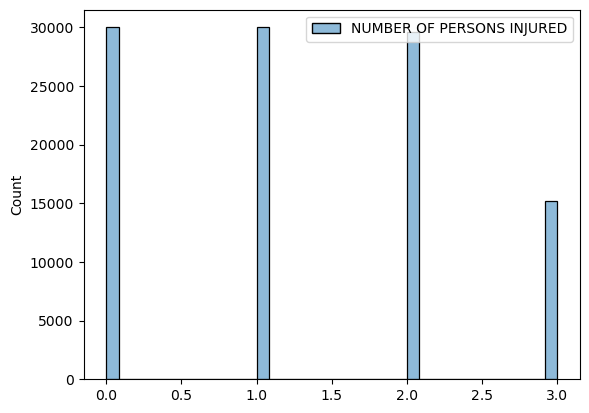

In [136]:
X = collisions.loc[:,['dayofweek', 'time', 'speed_bumps', 'speed_limits', 'bike_lanes', 'medianWeek', 'medianHour']]
y = collisions.loc[:,['NUMBER OF PERSONS INJURED']]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=random_state)
# seaborn histogram
sns.histplot(y)

In [137]:
# # bad fittings
# # I tried to predict the number of injuried, but couldn't get a good fitting. Thus, I redefined a classification problem.
# linear regression
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
print(reg.score(X_train, y_train))

# Multiclass LDA
clf = discriminant_analysis.LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))

0.005678898085881956
0.3167532485240179


In [138]:
# random forest
rd = ensemble.RandomForestClassifier()
rd.fit(X_train, y_train)
rd.score(X_train, y_train)
rd.score(X_test, y_test)

0.776604205771005